# Stitching multiple images

This notebook is used to find a solution to the multi-graph syncronization problem and stitch images together.

In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Variable definition

In [25]:
#directories
dataset_dir = 'datasets/mountain_dataset'
output_dir ="output"
g_matrix_filename = "G_mountain.npy"

In [26]:
#If true store the computed images on disk
save_output = False

## Function definition

In [27]:
#This function loads images from a specific folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

In [28]:
#This function splits a 3nx3n matrix into a set of 3x3 matrices
def get_states(x):
    x_small = x.transpose()
    res = [ x_small[:,i*3:(i+1)*3].transpose() for i in range(x_small.shape[1]//3)]
    return res

In [29]:
import skimage

# This function allows to stitch images together
def stitch_images(U, imgs, idx_ref, num, idxs=None, beautify=True):
    if not idxs:
        idxs = list(range(num))
    
    #Compute the homography of each image w.r.t. the reference one
    H = [np.dot(U[i],np.linalg.inv(U[idx_ref])) for i in range(num)]
    
    rescale = 1./np.max(imgs[idx_ref].shape)
    T_norm = np.diag([rescale,rescale,1])
    
    H = [ np.linalg.inv(T_norm) @ h @ T_norm  for h in H]
    
    min_x = 0
    min_y = 0
    max_x = 0
    max_y = 0
    
    #For each image
    for i in idxs:
        
         ## translate
        (Height, Width, _) = imgs[i].shape

        # Taking the matrix of initial coordinates of the corners of the secondary image
        # Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
        # Where (xt, yt) is the coordinate of the i th corner of the image. 
        InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
                                  [0, 0, Height - 1, Height - 1],
                                  [1, 1, 1, 1]])

        # Finding the final coordinates of the corners of the image after transformation.
        # NOTE: Here, the coordinates of the corners of the frame may go out of the 
        # frame(negative values). We will correct this afterwards by updating the 
        # homography matrix accordingly.
        FinalMatrix = np.dot(np.linalg.inv(H[i]), InitialMatrix)

        [x, y, c] = FinalMatrix
        x = np.divide(x, c)
        y = np.divide(y, c)

        c_min_x = min(x)
        c_min_y = min(y)
        c_max_x = max(x)
        c_max_y = max(y)
        
        if c_min_x < min_x:
            min_x = c_min_x
            
        if c_min_y < min_y:
            min_y = c_min_y
            
        if c_max_x > max_x:
            max_x = c_max_x
            
        if c_max_y > max_y:
            max_y = c_max_y

            
    size =  [5000,10000] # y,x
    
    if beautify:
        t = [-min_x,-min_y]
        dy = int(min(max_y - min_y, size[0]))
        dx = int(min(max_x - min_x, size[1]))
        size = [dy,dx]
    else:
        t = [0,0]        
        
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    
    stitch = np.zeros(size + [3], dtype=int)
       
    #For each image
    for i in idxs:
    
        # debug
        #print(x)
        #print(y)

        #H_proj = np.dot(H[i],Ht)

        #Apply the homography        
      #  img_proj = skimage.transform.warp(imgs[i], H[i],output_shape= size)
        img_proj = cv.warpPerspective(imgs[i], Ht @ np.linalg.inv(H[i]) , size[::-1])
        #plt.imshow(img_proj[:1000,:1000],),plt.show()
        
        print(np.linalg.det(H[i]))
        
        #Use maximum as stitch operator (very simple stitching mechanism)
        stitch = np.maximum(stitch,img_proj)
   
    
    return H, stitch

## Computation of the solution of the graph synchronization problem

In [30]:
#Load images from the folder
imgs = load_images_from_folder(dataset_dir)
n = len(imgs) #Number of images

#Load G matrix
G = np.load(os.path.join(output_dir,g_matrix_filename))

In [31]:
#u: left eigenvectors
#d: eigenvalues
#vh: right eigenvectors
u,d,vh = np.linalg.svd(G) #Application of SVD to the G matrix
v = vh.transpose() #Transpose matrix of right eigenvectors

In [32]:
# Find the three right singular vectors associated
# with the 3 smallest singular value (so the last 3 columns)
u_hat = v[:,[-1,-2,-3]]

In [33]:
np.dot( u_hat.transpose(), u_hat) #Check that the product Uhat_transpose*Uhat = I(3)

array([[ 1.00000000e+00,  1.73949240e-16,  4.12173571e-17],
       [ 1.73949240e-16,  1.00000000e+00, -1.69735383e-16],
       [ 4.12173571e-17, -1.69735383e-16,  1.00000000e+00]])

In [34]:
U = get_states(u_hat) #Get the state of each node

## Stitch images together

In [40]:
_,stitch = stitch_images(U, imgs, 0, n, beautify=True) #Stitch all the images

1.0000000000000004
1.0001335987594642
0.9998900108614682
0.9998439747192551
1.000020179500289
1.0004785556620621


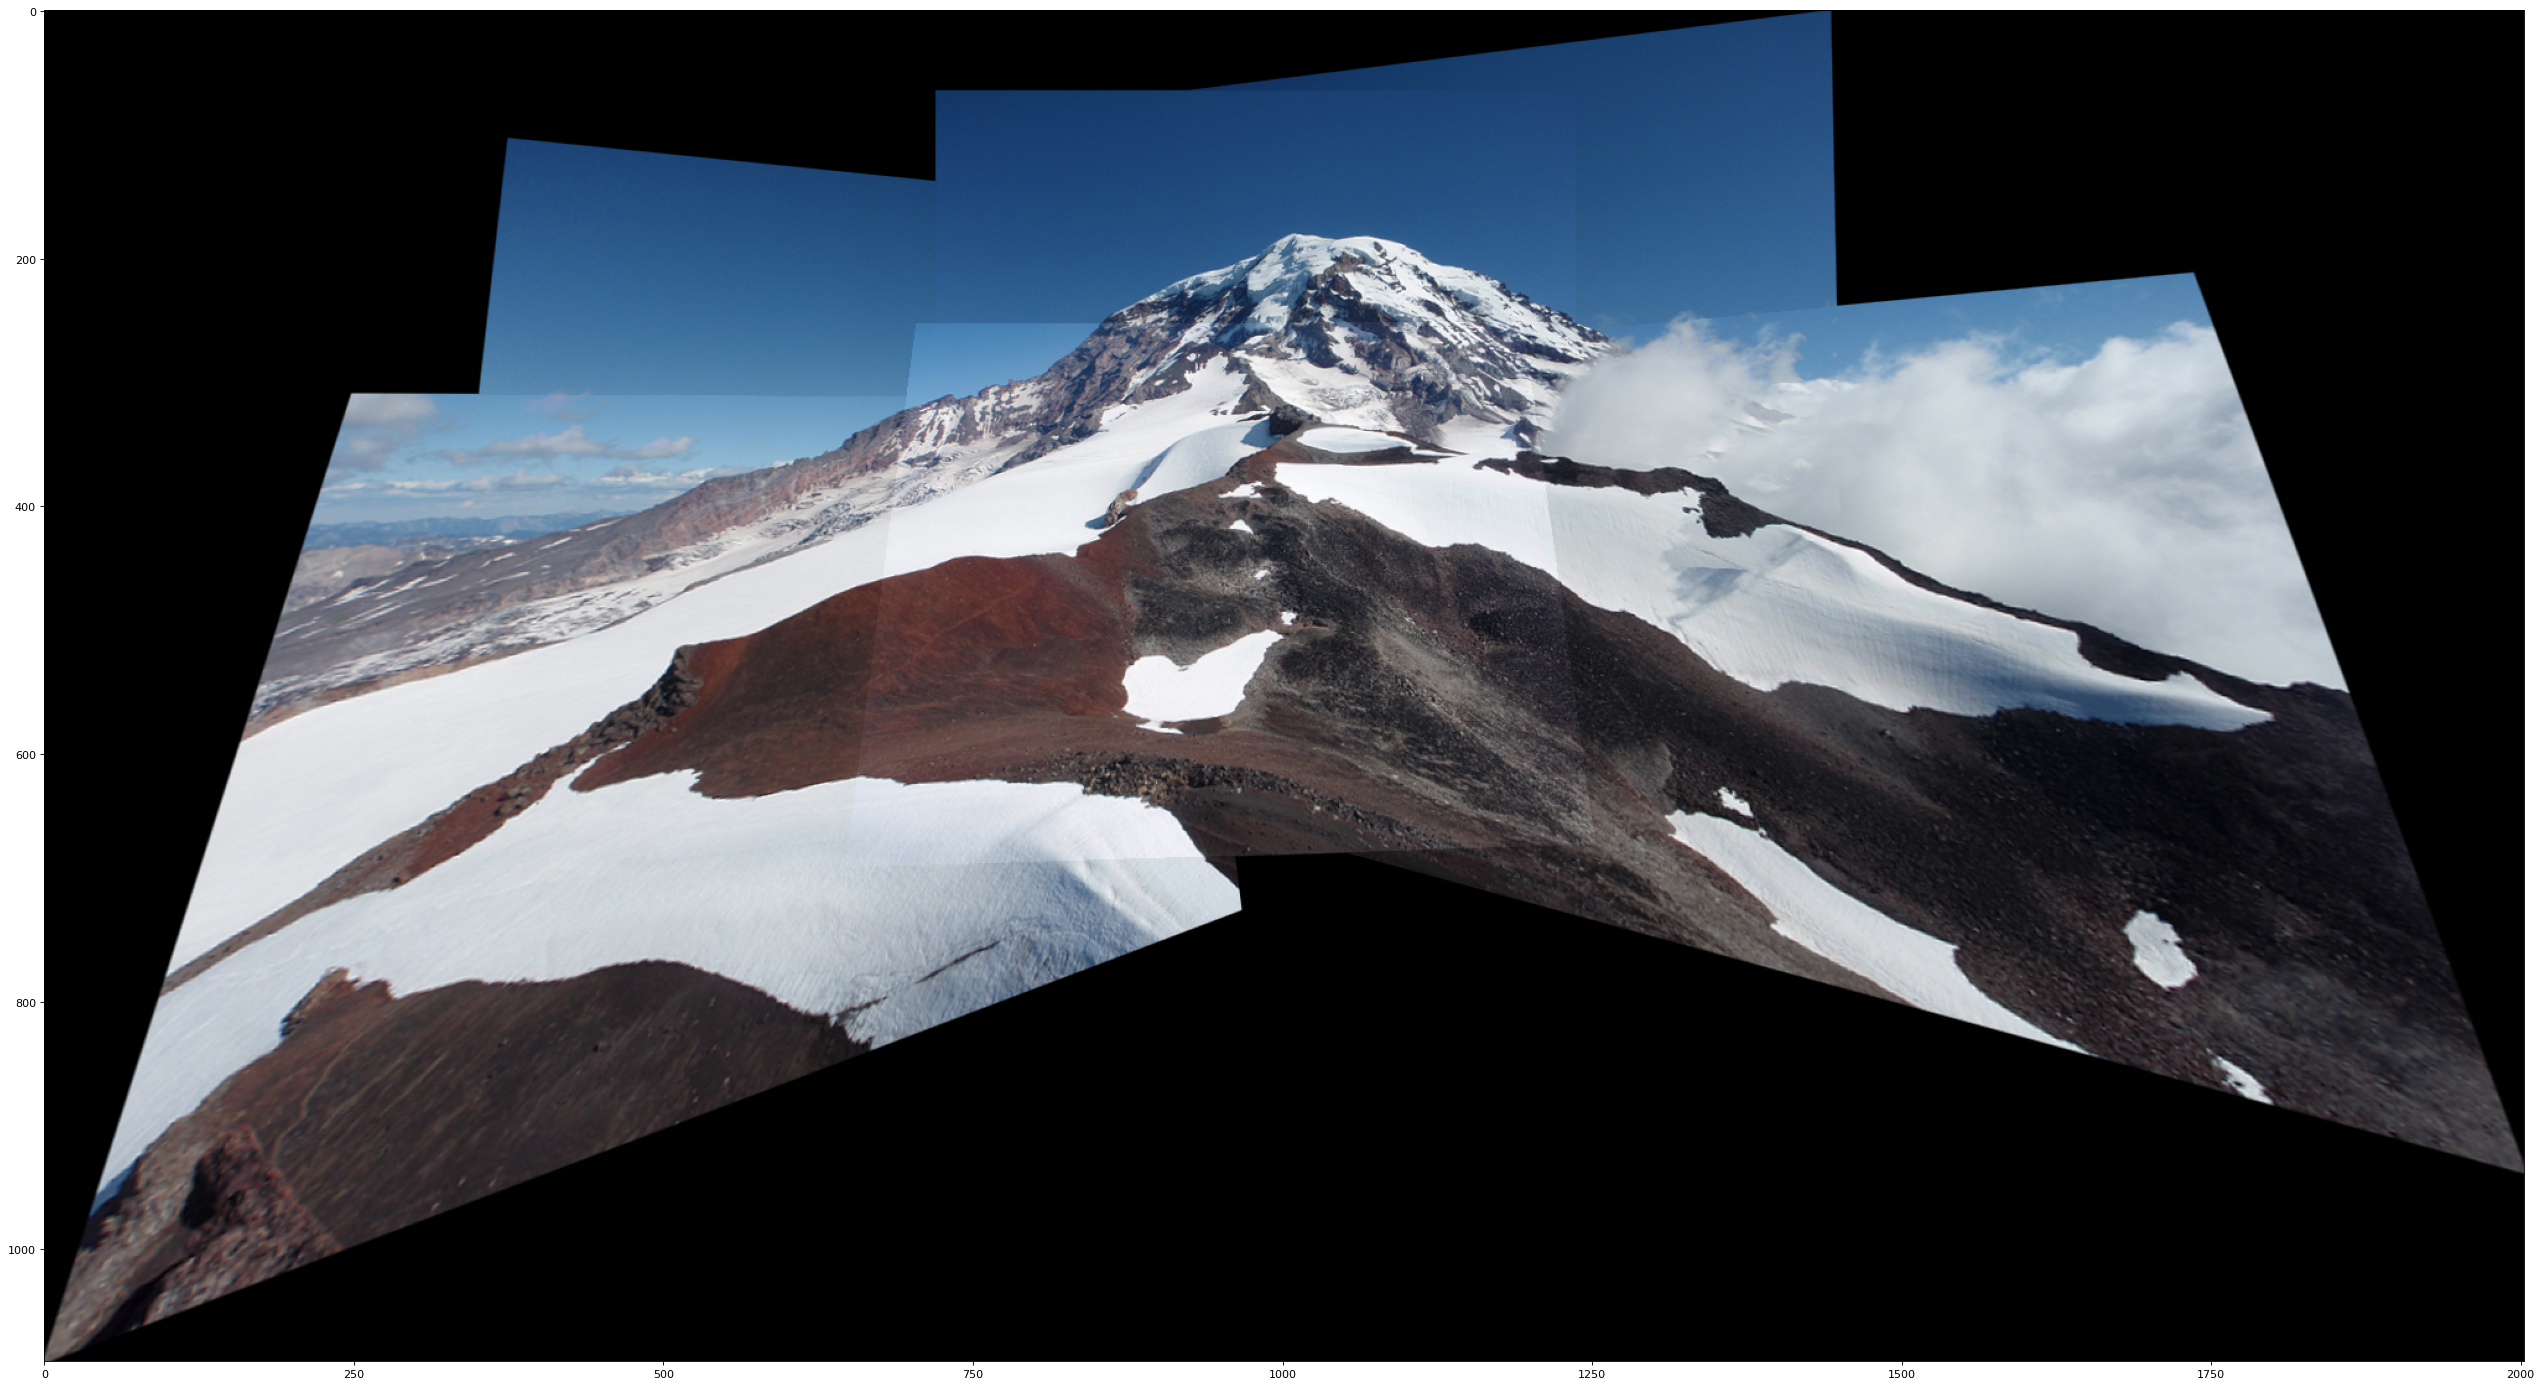

(<matplotlib.image.AxesImage at 0x17fa446b850>, None)

In [41]:
figure(figsize=(40, 40), dpi=80)
plt.imshow(stitch[:5000,:10000],),plt.show() #Plot stitched image

In [42]:
#The remaining part is just to stitch 2 images without applying the graph synchronization method
i1 = 4
i2 = 5

rescale = 1./np.max(imgs[i1].shape)
T_norm = np.diag([rescale,rescale,1])

h = G[(i2)*3:(i2+1)*3,(i1)*3:(i1+1)*3]

im_1 = cv.warpPerspective(imgs[i1], np.eye(3), [10000,5000])
im_2 = cv.warpPerspective(imgs[i2], np.linalg.inv( np.linalg.inv(T_norm) @ h @ T_norm), [10000,5000])  #np.dot(np.dot(np.linalg.inv(T_norm),h),T_norm)

In [38]:
stitch = np.maximum(im_1,im_2)

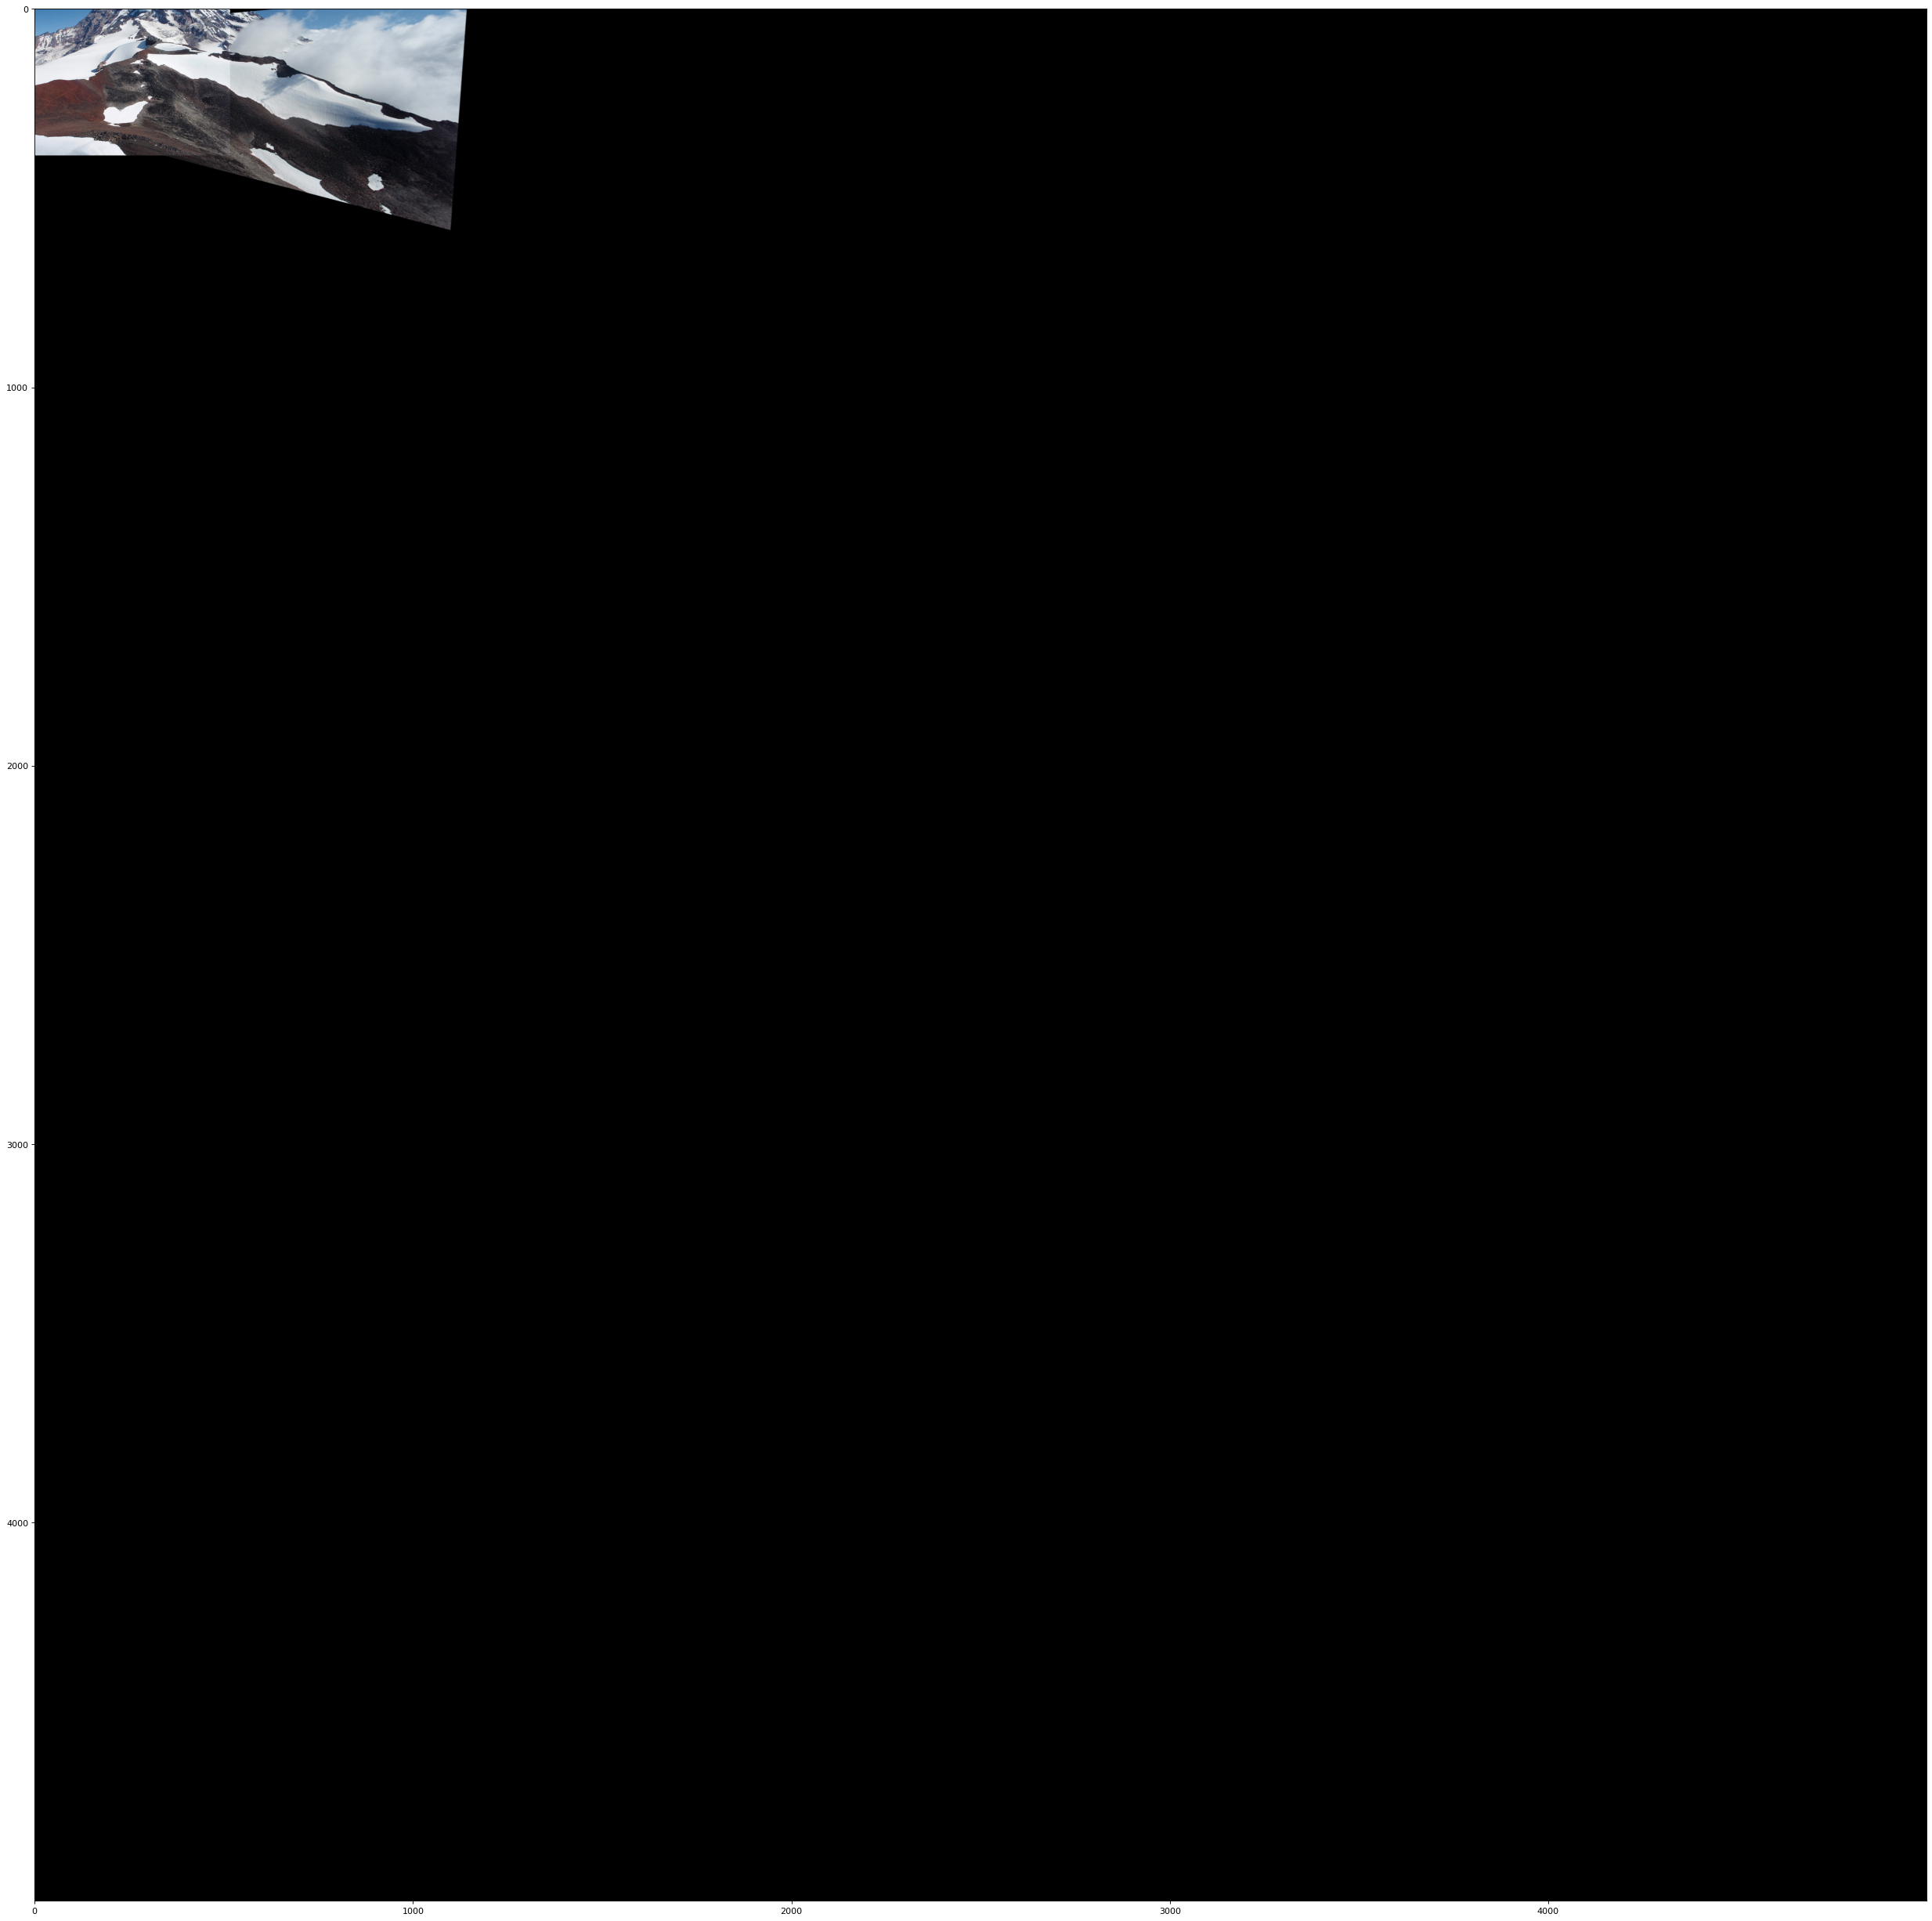

(<matplotlib.image.AxesImage at 0x17fa4425070>, None)

In [39]:
from matplotlib.pyplot import figure
figure(figsize=(40, 40), dpi=80)
plt.imshow(stitch[:10000,:5000],),plt.show()